In [1]:
import torch
from architecture import resnet50
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

In [2]:
# load classes names
with open('sets/classes.txt', 'r') as f:
    classes = [l.strip() for l in f.readlines()]
print('Loaded {} classes:'.format(len(classes)))
print('\n'.join(classes))

Loaded 10 classes:
11H(ANTONY OF PADUA)
11H(JOHN THE BAPTIST)
11H(PAUL)
11H(FRANCIS)
11HH(MARY MAGDALENE)
11H(JEROME)
11H(DOMINIC)
11F(MARY)
11H(PETER)
11H(SEBASTIAN)


In [3]:
# initialize model
num_classes = 10
gradmodel = resnet50.Grad(num_classes) # Own Modification
cammodel = resnet50.CAM(num_classes)

In [4]:
# load weights
weights_path = 'model/res50.pth'
gradmodel.load_state_dict(torch.load(weights_path), strict=True)
cammodel.load_state_dict(torch.load(weights_path), strict=True)
print('Model loaded')

Model loaded


In [5]:
# set model to be run on GPU
gradmodel.cuda()
cammodel.cuda()
# set model to run on eval mode
gradmodel.eval()
cammodel.eval()

In [6]:
standard_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Lambda(lambda x: torch.unsqueeze(x, 0))
])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


def get_cams(img, model):
    img_size = img.shape[2:]
    cams = model(img)
    high_res_cams = F.interpolate(cams, img_size, mode='bilinear', align_corners=False)
    high_res_cams = torch.squeeze(high_res_cams, 0)
    high_res_cams /= F.adaptive_max_pool2d(high_res_cams, (1, 1)) + 1e-5
    return high_res_cams

def get_score_indice(img, model, classes, class_to_check=None):
    output = model(img)
    if class_to_check:
        indice = classes.index(class_to_check)
        score = output[0][indice]
    else:
        score, indice = torch.max(output, 1)
        indice = indice.data[0]
    return score, indice

(898, 600, 3)


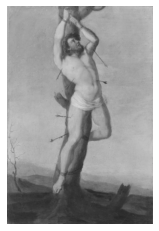

In [7]:
# load img
img_path = 'test-data/Q18599229.jpg'
image = np.asarray(imageio.imread(img_path))
print(image.shape)
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
def saliency(img, gradmodel, cammodel, classes, class_to_check=None, visual=False, smooth=False):
    '''Generates a VGA and CAM map. Will plot versions of them is visual=True'''
    if visual:
        img = standard_transform(img).cuda()
    img = torch.unsqueeze(img, 0)
    img.requires_grad = True
    
    score, indice = get_score_indice(img, gradmodel, classes, class_to_check)
    if score < 1:
        return None, None, None
    score.backward()
    slc = torch.max(torch.abs(img.grad[0]), dim=0)[0]
    vmax = torch.quantile(slc, 0.99)
    vmin = torch.min(slc)
    slc = torch.clamp(slc, vmin, vmax)
    slc = (slc - slc.min())/(slc.max()-slc.min())
    
    
    class_name = classes[indice]
    
    high_res_cams = get_cams(img, cammodel)
    high_res_cam = high_res_cams[indice].detach()
    vmax = torch.quantile(high_res_cam, 0.99)
    vmin = torch.min(high_res_cam)
    high_res_cam = torch.clamp(high_res_cam, vmin, vmax)
    high_res_cam = (high_res_cam - high_res_cam.min())/(high_res_cam.max()-high_res_cam.min())

    if visual:
        with torch.no_grad():
            input_img = inv_normalize(img[0])
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(high_res_cam.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(high_res_cam.cpu().numpy(), cmap=plt.cm.hot, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
        #Create an importance agreement map
        slc_importance = slc >= 0.5
        cam_importance = high_res_cam >= 0.5
        agreement_map = torch.logical_and(slc_importance, cam_importance)

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(agreement_map.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
    return slc, high_res_cam, class_name

In [9]:
def smoothgrad(img, gradmodel, classes, class_to_check=None, stdev=0.15, nsamples=25, visual=False):
    '''Generates a smoothgrad map. Will plot versions of it is visual=True'''
    if visual:
        img = standard_transform(img).cuda()
    img = torch.unsqueeze(img, 0)
    img.requires_grad = True
    
    score, indice = get_score_indice(img, gradmodel, classes, class_to_check)
    if score < 1:
        return None, None, None
    img.requires_grad = False
    
    if class_to_check == False:
        class_to_check = classes[indice]
        
    total_gradients = torch.zeros_like(img[0][0])
    
    for _ in range(nsamples):
        noise = torch.normal(0, stdev, img.shape).cuda()
        img_plus_noise = img + noise
        img_plus_noise.requires_grad = True
        
        score, indice = get_score_indice(img_plus_noise, gradmodel, classes, class_to_check)
    
        score.backward()
        slc = torch.max(torch.abs(img_plus_noise.grad[0]), dim=0)[0]
        vmax = torch.quantile(slc, 0.99)
        vmin = torch.min(slc)
        slc = torch.clamp(slc, vmin, vmax)
        slc = (slc - slc.min())/(slc.max()-slc.min())
        
        total_gradients += (slc * slc)
        
    smoothgrad = total_gradients / nsamples

    if visual:
        with torch.no_grad():
            input_img = inv_normalize(img[0])
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(smoothgrad.cpu().numpy(), cmap=plt.cm.hot, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(smoothgrad.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

    return smoothgrad, class_to_check

In [10]:
def intgrad(img, gradmodel, classes, class_to_check=None, x_steps=25, visual=False):
    '''Generates an integrated gradients map. Will plot versions of it is visual=True'''
    if visual:
        img = standard_transform(img).cuda()
    img = torch.unsqueeze(img, 0)
    img.requires_grad = True
    
    score, indice = get_score_indice(img, gradmodel, classes, class_to_check)
    if score < 1:
        return None, None, None
    img.requires_grad = False
    
    if class_to_check == False:
        class_to_check = classes[indice]
    
    baseline = torch.zeros_like(img[0])
    #baseline = torch.full_like(img[0], 2)
    total_gradients = torch.zeros_like(img[0])
    
    diff = img[0] - baseline
    #diff = baseline - img[0]
    
    for alpha in torch.linspace(0, 1, x_steps).cuda():
        x_step = baseline + alpha * diff
        #x_step = baseline - alpha * diff
        x_step = torch.unsqueeze(x_step, dim=0)
        x_step.requires_grad = True
        
        score, indice = get_score_indice(x_step, gradmodel, classes, class_to_check) 
        score.backward()
        slc = x_step.grad[0]
        
        total_gradients += slc
    
    integrated_gradients = total_gradients * diff / x_steps
    
    integrated_gradients = torch.max(torch.abs(integrated_gradients), dim=0)[0]
    vmax = torch.quantile(integrated_gradients, 0.99)
    vmin = torch.min(integrated_gradients)
    slc = torch.clamp(integrated_gradients, vmin, vmax)
    integrated_gradients = (slc - slc.min())/(slc.max()-slc.min())
    
    if visual:
        with torch.no_grad():
            input_img = inv_normalize(img[0])
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(integrated_gradients.cpu().numpy(), cmap=plt.cm.hot, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(integrated_gradients.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
    #del img, score, indice, baseline, total_gradients, diff, x_step, slc, gradmodel

    return integrated_gradients, class_to_check

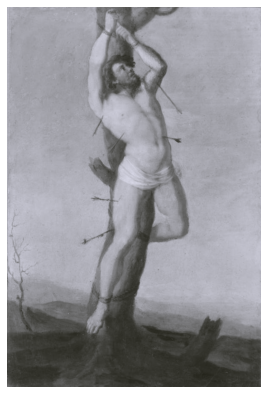

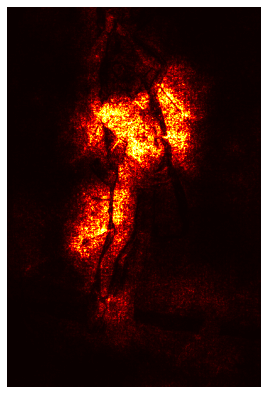

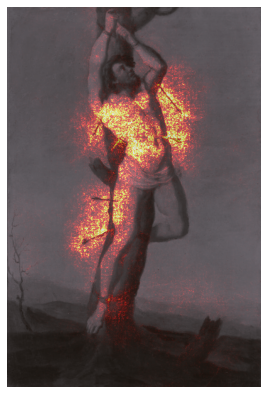

In [11]:
intgrad_value, class_name = intgrad(image, gradmodel, classes, class_to_check=None, x_steps=25, visual=True)

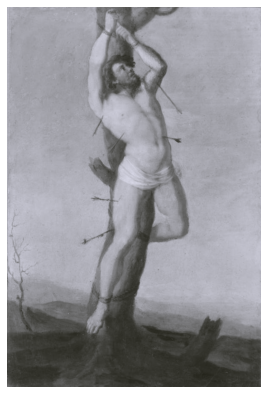

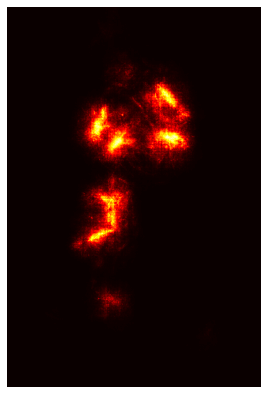

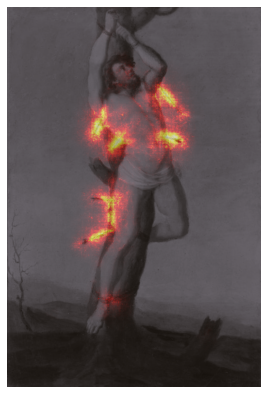

In [12]:
smoothgrad_value, class_name = smoothgrad(image, gradmodel, classes, class_to_check=None, stdev=0.15, nsamples=25, visual=True)

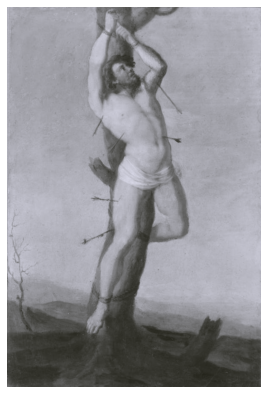

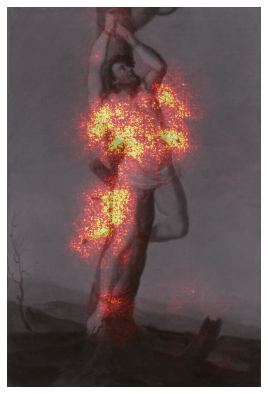

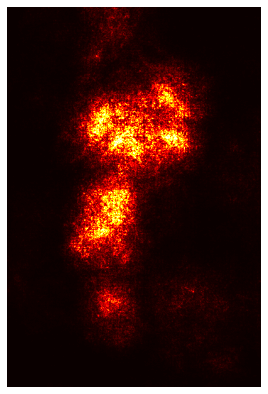

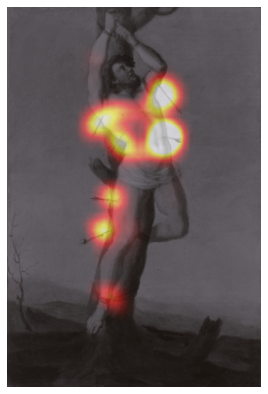

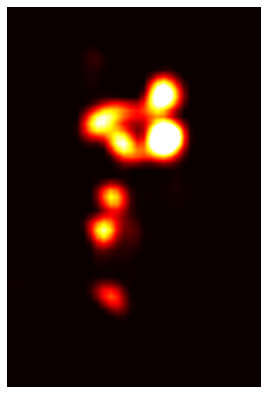

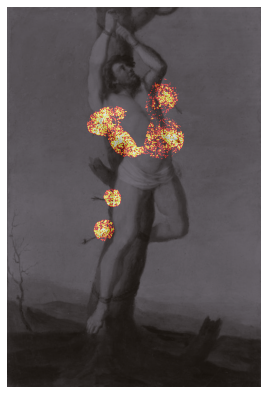

In [13]:
slc, cam, class_name = saliency(image, gradmodel, cammodel, classes, visual=True)

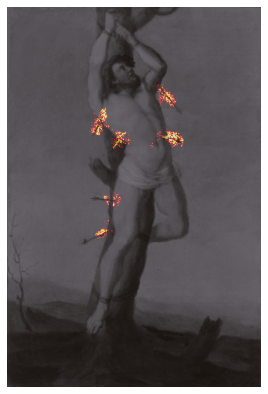

11H(SEBASTIAN)


In [14]:
# This block of code can be run after the above 3 to create an importance agreement map for all 4 methods.

image_tmp = standard_transform(image).cuda()
image_tmp = torch.unsqueeze(image_tmp, 0)
with torch.no_grad():
    input_img = inv_normalize(image_tmp[0])
    
slc_importance = slc >= 0.5
cam_importance = cam >= 0.5
smooth_importance = smoothgrad_value >= 0.5
intgrad_importance = intgrad_value >= 0.5

agreement_map_vga_ig = torch.logical_and(slc_importance, intgrad_importance)
agreement_map_cam_smooth = torch.logical_and(cam_importance, smooth_importance)

total_agreement_map = torch.logical_and(agreement_map_vga_ig, agreement_map_cam_smooth)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
plt.imshow(total_agreement_map.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
plt.axis('off')
plt.show()

print(class_name)

In [16]:
def create_subset(size_per_saint, classes):
    '''A function to create custom subsets of the images for measurment purposes.'''
    classes_path = 'DEVKitArtDL/DEVKitArt/ImageSets/Main' # Depends on where the dataset is located
    
    arr = np.array([])
    
    for saint in classes:
        class_size = 0
        class_path = classes_path + "/" + saint + '_train.txt'
        class_array = np.loadtxt(class_path, dtype=str)
        for image in class_array:
            if image[1] == '1':
                arr = np.append(arr, (image[0]))
                class_size += 1
            if class_size == size_per_saint:
                break
    np.savetxt(classes_path + '/' + classes[0] + '_' + str(size_per_saint) + '_train.txt', arr, fmt='%s')

In [17]:
#create_subset(100, ['11H(SEBASTIAN)'])

In [18]:
def comparison(slc, cam):
    '''Applies the comparison methods to a VGA and CAM map.'''
    slc_total = torch.sum(slc)
    cam_total = torch.sum(cam)
    diff = torch.abs(slc_total - cam_total)
    avg_dis = diff / torch.numel(slc)
    slc_importance = slc >= 0.5
    cam_importance = cam >= 0.5
    avg_importance_count = torch.round(torch.sum(slc_importance == True) + torch.sum(cam_importance == True) / 2) 
    agreement = torch.sum((slc_importance == cam_importance) * (slc_importance == True))
    agreement_percentage = agreement / avg_importance_count
    return avg_dis, agreement_percentage

def avg_diss(totals, pixel_count):
    avg_diss = torch.zeros(len(totals), len(totals))
    i=0
    while i <= len(totals):
        j=i+1
        while j+1 <= len(totals):
            avg_diss[i][j] = torch.abs(totals[i] - totals[j]) / pixel_count
            avg_diss[j][i] = torch.abs(totals[i] - totals[j]) / pixel_count
            j += 1
        i += 1
    return avg_diss

def agreement_prcntgs(importance_maps):
    agreement_percentages = torch.zeros(len(importance_maps), len(importance_maps))
    i=0
    while i <= len(importance_maps):
        j=i+1
        while j+1 <= len(importance_maps):
            avg_importance_count = torch.round(torch.sum(importance_maps[i] == True) + torch.sum(importance_maps[j] == True) / 2)
            agreement = torch.sum((importance_maps[i] == importance_maps[j]) * (importance_maps[i] == True))
            agreement_percentages[i][j] = agreement / avg_importance_count
            agreement_percentages[j][i] = agreement / avg_importance_count
            j += 1
        i += 1
    return agreement_percentages

def comparison_full(slc, cam, smoothgrad, intgrad):
    '''Applies the comparison methods to all four saliency methods.'''
    slc_total = torch.sum(slc)
    cam_total = torch.sum(cam)
    smoothgrad_total = torch.sum(smoothgrad)
    intgrad_total = torch.sum(intgrad)
    
    totals = torch.as_tensor([[slc_total], [cam_total], [smoothgrad_total], [intgrad_total]])
    avg_distances = avg_diss(totals, torch.numel(slc))
    
    slc_importance = slc >= 0.5
    cam_importance = cam >= 0.5
    smoothgrad_importance = smoothgrad >= 0.5
    intgrad_importance = intgrad >= 0.5
    
    importance_maps = torch.stack([slc_importance, cam_importance, smoothgrad_importance, intgrad_importance], dim=0)   
    agreement_percentages = agreement_prcntgs(importance_maps)
    return avg_distances, agreement_percentages

In [57]:
# This block of code is used to create a dataloader for any set of images.

class_to_check = '11H(SEBASTIAN)_100'
#class_to_check = '100'

classes_path = 'DEVKitArtDL/DEVKitArt/ImageSets/Main'
class_path = classes_path + "/" + class_to_check + '_train.txt'

class_to_check = '11H(SEBASTIAN)'

if class_to_check not in classes:
    class_array = np.loadtxt(class_path, dtype=str)
else:
    class_array = np.loadtxt(class_path, dtype=str).T


def is_correct_class(string):
    if string[-4:] != '.jpg':
        return False
    if class_to_check[:-4] not in classes:
        if string[33:-4] in class_array:
            return True
        else:
            return False
    else:
        i = np.where(class_array[0] == string[33:-4])[0]
        if class_array[1][i] == '1':
            return True
        else:
            return False
    
dataset = torchvision.datasets.ImageFolder(root='DEVKitArtDL/DEVKitArt', transform = standard_transform, is_valid_file = is_correct_class)
#dataset = torchvision.datasets.ImageFolder(root='DEVKitArtDL/DEVKitArt', transform = standard_transform)
standardloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

print(len(standardloader))

100


In [19]:
avg_distances, agreement_percentages = [], []

def com_analysis(standardloader, gradmodel, cammodel, classes, class_to_check=None):
    '''Run VGA, CAM comparison on dataloader'''
    avg_distances, agreement_percentages = [], []
    for i, data in enumerate(standardloader, 0):
        if i % 500 == 0:
            print(i / len(standardloader))
        for j in data[0]:
            if j.shape[1] > 3000 or j.shape[2] > 3000: # safeguard for files that are too big for my GPU to handle
                continue
            slc, cam, class_name= saliency(j.cuda(), gradmodel, cammodel, classes, class_to_check)
            if class_name == None:
                continue  
            avg_dis, agreement_percentage = comparison(slc, cam)
            avg_distances.append(avg_dis.item())
            agreement_percentages.append(agreement_percentage.item())
    return avg_distances, agreement_percentages

def com_analysis_full(standardloader, gradmodel, cammodel, classes, class_to_check=None):
    '''Run VGA, CAM, smoothgrad, integrated gradients, comparisons on dataloader'''
    all_avg_distances, all_agreement_percentages = [], []
    for i, data in enumerate(standardloader, 0):
        if i % 10 == 0:
            print(i / len(standardloader))
        for j in data[0]:
            if j.shape[1] > 3000 or j.shape[2] > 3000: # safeguard for files that are too big for my GPU to handle
                continue
            slc, cam, class_name= saliency(j.cuda(), gradmodel, cammodel, classes, class_to_check)
            if class_name == None:
                continue
            smooth, class_name = smoothgrad(j.cuda(), gradmodel, classes, class_to_check)
            intg, class_name = intgrad(j.cuda(), gradmodel, classes, class_to_check)
            avg_distances, agreement_percentages = comparison_full(slc, cam, smooth, intg)

            if all_avg_distances == []:
                all_avg_distances = avg_distances.unsqueeze(0)
                all_agreement_percentages = agreement_percentages.unsqueeze(0)
            else:
                all_avg_distances = torch.cat((all_avg_distances, avg_distances.unsqueeze(0)))
                all_agreement_percentages = torch.cat((all_agreement_percentages, agreement_percentages.unsqueeze(0)))
                   
    avg_distances = torch.sum(all_avg_distances, 0) / len(all_avg_distances)
    agreement_percentages = torch.sum(all_agreement_percentages, 0) / len(all_agreement_percentages)

    return avg_distances, agreement_percentages

In [58]:
# Runs the functions for calculating comparisons between all 4 saliency methods

avg_distances, agreement_percentages = com_analysis_full(standardloader, gradmodel, cammodel, classes)#, class_to_check=class_to_check)

torch.save(avg_distances, 'saliency/full_avg_distances_' + class_to_check + '.pt')
torch.save(agreement_percentages, 'saliency/full_agreement_percentages_'  + class_to_check + '.pt')

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [11]:
a = torch.load('saliency/full_avg_distances_11H(SEBASTIAN).pt')
b = torch.load('saliency/full_agreement_percentages_11H(SEBASTIAN).pt') 
print(a)
print(b)

tensor([[0.0000, 0.0413, 0.0445, 0.0107],
        [0.0413, 0.0000, 0.0084, 0.0394],
        [0.0445, 0.0084, 0.0000, 0.0421],
        [0.0107, 0.0394, 0.0421, 0.0000]])
tensor([[0.0000, 0.3070, 0.2645, 0.3586],
        [0.3070, 0.0000, 0.3121, 0.2834],
        [0.2645, 0.3121, 0.0000, 0.2813],
        [0.3586, 0.2834, 0.2813, 0.0000]])


In [22]:
# This block of code compiles the results from the tensors of the seperate classes.

final_avg_distances, final_agreement_percentages = [], []

for x in classes:
    avg_distances = torch.load('saliency/full_avg_distances_' + x + '.pt')
    agreement_percentages = torch.load('saliency/full_agreement_percentages_' + x + '.pt')
    if final_avg_distances == []:
        final_avg_distances = avg_distances.unsqueeze(0)
        final_agreement_percentages = agreement_percentages.unsqueeze(0)
    else:
        final_avg_distances = torch.cat((final_avg_distances, avg_distances.unsqueeze(0)))
        final_agreement_percentages = torch.cat((final_agreement_percentages, agreement_percentages.unsqueeze(0)))

avg_distances = torch.sum(final_avg_distances, 0) / len(final_avg_distances)
agreement_percentages = torch.sum(final_agreement_percentages, 0) / len(final_agreement_percentages)
print(avg_distances)
print(agreement_percentages)

tensor([[0.0000, 0.0440, 0.0509, 0.0103],
        [0.0440, 0.0000, 0.0111, 0.0411],
        [0.0509, 0.0111, 0.0000, 0.0479],
        [0.0103, 0.0411, 0.0479, 0.0000]])
tensor([[0.0000, 0.2725, 0.2623, 0.3428],
        [0.2725, 0.0000, 0.2697, 0.2489],
        [0.2623, 0.2697, 0.0000, 0.2736],
        [0.3428, 0.2489, 0.2736, 0.0000]])


In [ ]:
# Runs the functions for comparing between VGA and CAM

avg_distances, agreement_percentages = com_analysis(standardloader, gradmodel, cammodel, classes, class_to_check=class_to_check)
np_avg_distances = np.array(avg_distances)
np_agreement_percentages = np.array(agreement_percentages)

In [56]:
np.savetxt("saliency/np_avg_distances.csv", np_avg_distances, delimiter=",")
np.savetxt("saliency/np_agreement_percentages.csv", np_agreement_percentages, delimiter=",")

In [26]:
np_avg_distances = np.loadtxt("saliency/np_avg_distances.csv")
np_agreement_percentages = np.loadtxt("saliency/np_agreement_percentages.csv")

print("Average Distance per pixel:")       
print(sum(np_avg_distances) / len(np_avg_distances))
print("Average importance agreement per image:")
print(sum(np_agreement_percentages) / len(np_agreement_percentages))

Average Distance per pixel:
0.04192818501753546
Average importance agreement per image:
0.2363789214999065
